In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
# disentangled vae
sys.path.append('../disentangling-vae')
from collections import defaultdict
import vae_trim, vae_trim_viz
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import get_loss_f
# visualization disvae
from utils.visualize import Visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
args = vae_trim_viz.parse_arguments()
args.loss = "btcvae"
args.reg_anneal = 0
args.btcvae_B = 3
args.attr_lamb = 60
# name = args.loss + "_B_" + str(args.btcvae_B) + "_attr_" + str(args.attr_lamb) + "_bijection"
name = "btcvae_B_3"
args.name = name

args.plots = "all"
args.n_rows = 10
args.n_cols = 10

In [27]:
# results dir
model_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(64, 1000, device)
metadata = load_metadata(model_dir)

# load model
model = load_model(model_dir, is_gpu=True)
model.eval()

# visualizer
viz = Visualizer(model=model,
                 model_dir=model_dir,
                 save_images=False,
#                  dataset=metadata['dataset'],
                 dataset='mnist',
                 max_traversal=args.max_traversal,
                 loss_of_interest='kl_loss_',
                 upsample_factor=args.upsample_factor)
size = (args.n_rows, args.n_cols)
num_samples = args.n_cols * args.n_rows
# get samples
idcs = random.sample(range(len(test_loader.dataset)), num_samples)
samples = torch.stack([test_loader.dataset[i][0] for i in idcs], dim=0)


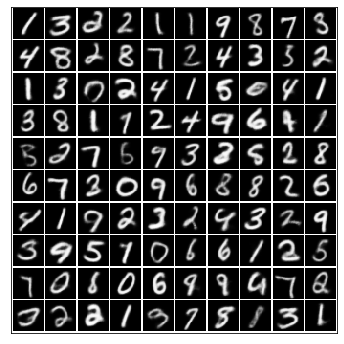

In [28]:
# generate samples
plt.figure(figsize=(6,6))
plt.imshow(viz.generate_samples(size=size), interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

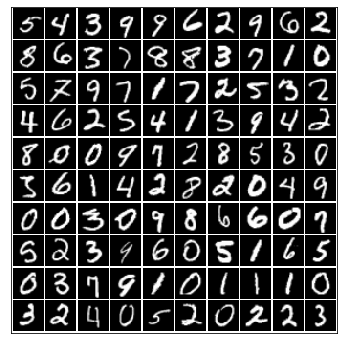

In [29]:
# data samples
plt.figure(figsize=(6,6))
plt.imshow(viz.data_samples(data=samples, size=size), interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

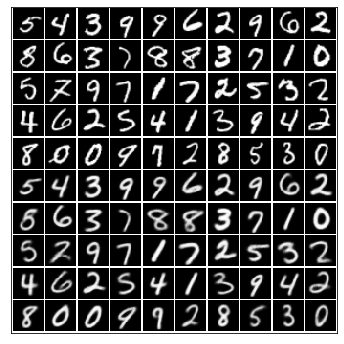

In [30]:
# reconstruct
plt.figure(figsize=(6,6))
plt.imshow(viz.reconstruct(data=samples, size=size), interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

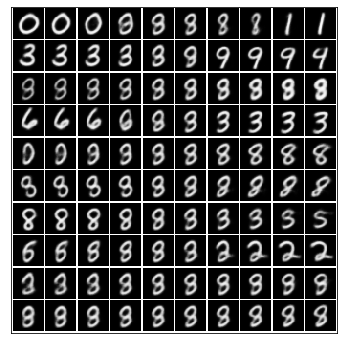

In [31]:
# prior traversals
plt.figure(figsize=(6,6))
plt.imshow(viz.traversals(data=samples[0:1, ...] if args.is_posterior else None,
               n_per_latent=size[1],
               n_latents=size[0],
               is_reorder_latents=False), interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

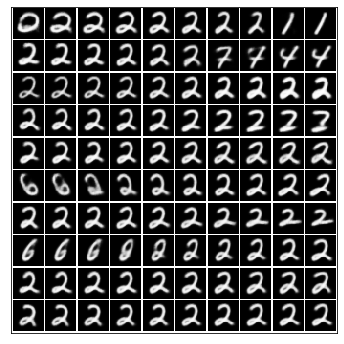

In [32]:
# posterior traversals
plt.figure(figsize=(6,6))
plt.imshow(viz.traversals(data=samples[6:7, ...],
               n_per_latent=size[1],
               n_latents=size[0],
               is_reorder_latents=False), interpolation='nearest')
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)